# Figures for the Paper

Python code for generating figures used in the paper "The Frequency
and Sizes of Inner Bars and Nuclear Rings in Barred Galaxies and Their
Dependence on Galaxy Properties" (Erwin 2023, submitted)

## Requirements

This notebook is meant to be run within the full **db-nr_paper** repository, including the associated Python modules and data files.

In addition, this notebook requires, directly or indirectly, the following Python packages:
   * numpy
   * scipy
   * matplotlib

By default, output PDF figure files are *not* saved to disk; to enable this, set the `savePlots` variable in the **Setup** cell to `True` and change the `plotDir` variable (same cell) to point to where you want the figures saved.

## Initial Setup

### General Setup

In [2]:
%matplotlib inline

from matplotlib.pyplot import plot, xlim, ylim, title, legend, xlabel, ylabel
from matplotlib.pyplot import subplots_adjust, text, savefig, gca, clf, hist
from matplotlib.pyplot import loglog, semilogx, semilogy

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20


In [9]:
import copy
import scipy.stats
import numpy as np

baseDir = "/Users/erwin/Documents/Working/Papers/Paper-extended-wiyn-survey/public/"
dataDir = baseDir
plotDir = baseDir + "plots/"
sys.path.append(baseDir)

import dbnr_utils
import plotutils as pu



unbarredInfoFile = "/Users/erwin/Documents/Working/Papers/Paper-extended-wiyn-survey/sample_unbarred_info_d30b.txt"

df_bars, gnames_bars_rowdict = dbnr_utils.GetBarredGalaxyData(dataDir + "table_mainsample.dat")
nBarredGalaxies = len(df_bars.name)


mm = np.arange(8,12,0.01)

# set the following to True in order to save the figures as PDF files
savePlots = False


In [14]:
xtmstar = r"$\log \: (M_{\star} / M_{\odot})$"
xtdist = r"Distance [Mpc]"
ytbarsize_kpc_amax = r"Bar size $a_{\rm max}$ [kpc, deprojected]"
ytbarsize_kpc_Lbar = r"Bar size $L_{\rm bar}$ [kpc, deprojected]"
ytbarsize_kpc_s4g = r"Bar size $a_{\rm vis}$ [kpc, deprojected]"
ytbarsize_kpc_both = r"Bar size $a_{\rm vis}$ or $a_{\rm max}$ [kpc, deprojected]"
ytbarsize_kpc_nr = r"Bar or NR size [kpc, deprojected]"
ytbarsize_kpc_obs = r"Observed bar size $a_{\rm vis}$ [kpc]"


In [15]:
ii_db = [i for i in range(nBarredGalaxies) if df_bars.dbFlag[i]]
ii_nondb = [i for i in range(nBarredGalaxies) if i not in ii_db]

ii_nr = [i for i in range(nBarredGalaxies) if df_bars.nrFlag[i]]
ii_nonnr = [i for i in range(nBarredGalaxies) if i not in ii_nr]


In [16]:
len(ii_db)

31

## Figures: DB and NR fraction vs stellar mass

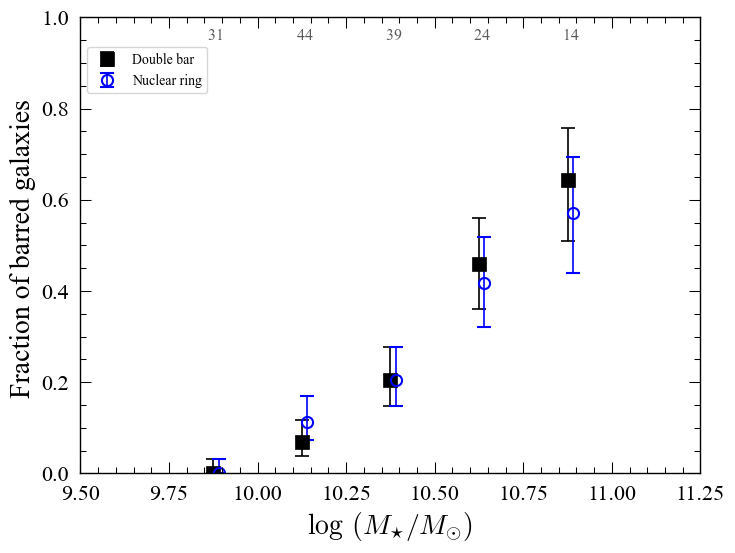

In [17]:
pu.PlotFrequency(df_bars.logmstar, ii_db, ii_nondb, 9.5, 11.25, 0.25, fmt='ks',ms=10,label='Double bar')
pu.PlotFrequency(df_bars.logmstar, ii_nr, ii_nonnr, 9.5, 11.25, 0.25, offset=0.015,noErase=True,
                 fmt='o',mfc='None',mec='blue',color='blue',mew=1.5,ms=8,label="Nuclear ring")
xlim(9.5,11.25);ylim(0,1)

# add bin counts
binranges = np.arange(9.75, 11.25,0.25)
i_all = ii_db + ii_nondb
(n_all, bin_edges) = np.histogram(df_bars.logmstar[i_all], binranges)
n_all_int = [round(n) for n in n_all]
for i in range(len(n_all_int)):
    x = binranges[i]
    n = n_all_int[i]
    text(x + 0.1, 0.95, "%3d" % n, fontsize=11.5, color='0.35')

legend(loc='upper left', bbox_to_anchor=(0,0,1,0.95), fontsize=10)

xlabel(xtmstar);ylabel("Fraction of barred galaxies ")
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir+"fDB-NR_vs_logMstar_barred-galaxies.pdf")


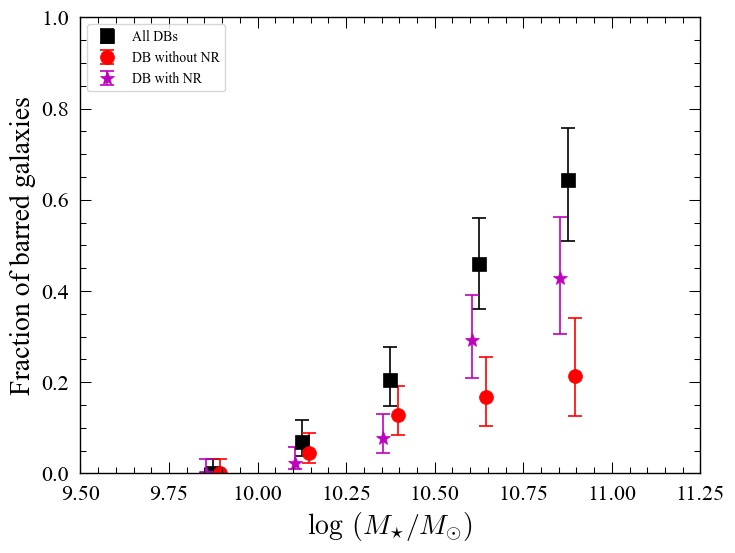

In [21]:
# DB without NR
ii_db_nonnr = [i for i in ii_db if i not in ii_nr]
# all other galaxies (no DB and DB+NR)
ii_non_db_nonnr = [i for i in range(nBarredGalaxies) if i not in ii_db_nonnr]

# DB with NR
ii_db_and_nr = [i for i in ii_db if i in ii_nr]
# NR without DB
ii_nr_nondb = [i for i in ii_nr if i not in ii_db]
# galaxies without DB+NR
ii_non_db_and_nr = [i for i in range(nBarredGalaxies) if i not in ii_db_and_nr]

# NOTE: see cell that makes and saves "fNR_vs_logMstar_all.pdf" for similar plots for NRs
# (all NR, NR w/ or w/o DB)

pu.PlotFrequency(df_bars.logmstar, ii_db, ii_nondb, 9.5, 11.25, 0.25, fmt='ks', ms=10, label='All DBs')
pu.PlotFrequency(df_bars.logmstar, ii_db_nonnr, ii_non_db_nonnr, 9.5, 11.25, 0.25, offset=0.02, 
                 noErase=True, fmt='ro', ms=10, label='DB without NR')
pu.PlotFrequency(df_bars.logmstar, ii_db_and_nr, ii_non_db_and_nr, 9.5, 11.25, 0.25, offset=-0.02, 
                 noErase=True, fmt='m*', ms=10, label='DB with NR')
legend(loc='upper left', fontsize=10)
xlim(9.5,11.25);ylim(0,1)
xlabel(xtmstar);ylabel("Fraction of barred galaxies")
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir+"fDB-with-without-NR_vs_logMstar_all.pdf")